# 2D_CNN_MRS_ordinal

## Explainable Artificial Intelligence for MRI Images of Stroke Patients


### Master of Science in Egineering - Technical Specialization Project II
#### Autor: Loran Avci (avci@zhaw.ch)
#### Supervisors: Dr. Beate Sick (sick@zhaw.ch) , Dr. Helmut Grabner (grbn@zhaw.ch) 



## 00 SETUP 

+ Load libraries
+ Read Data

In [1]:
!nvidia-smi
! pip install opencv-python
! apt-get update 
! apt-get install ffmpeg libsm6 libxext6  -y
! pip install lime

Sat Jun 26 10:04:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:65:00.0 Off |                  N/A |
| 40%   31C    P0    92W / 280W |     93MiB / 24217MiB |     73%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
import h5py
import os
import pandas as pd
import random
from os.path import exists
import tensorflow as tf
import cv2
from keras.applications.vgg16 import preprocess_input


print(os.getcwd())
print(tf.__version__)
tf.random.set_seed(2021)

/tf/notebooks/avci/XAI
2.2.0


Using TensorFlow backend.


In [3]:
# Create a folder for the output
output_folder = '/tf/notebooks/avci/XAI/mrs/'
if not exists(output_folder):
    print("crated dir")
    os.makedirs(output_folder)
    os.makedirs(output_folder + "/checkpoints")

## 01 Read Data

In [4]:
# Read in the data from the hdf5 file
def decode_data(string):
    decoded_string = [n.decode("UTF-8", "ignore") for n in string]
    return(decoded_string)

with h5py.File('/tf/notebooks/data/data_oct_18.h5', 'r') as h5:
    print('H5-file: ', list(h5.keys()))
    # Image matrices
    X = h5["X"][:]
    # Image labels (1=stroke, 0=no-stroke)
    Y_img = h5["Y"][:]
    # Patient ID's
    pat = h5["pat"][:]
    ##Image names/number
    #img = np.array(decode_data(h5["img_id"][:]))
    # Patient labels (1=stroke, 0=TIA)
    Y_pat = h5["stroke"][:]
    
print(len(X), len(Y_img), len(Y_pat), len(pat))


H5-file:  ['X', 'Y', 'img_id', 'pat', 'path', 'stroke']
15214 15214 15214 15214


In [5]:
# tabular data
INPUT_TAB = "/tf/notebooks/avci/XAI/data/patient_data_DWI_Zurich_imputed.csv"
dat = pd.read_csv(INPUT_TAB, sep = ',')
# change values to numbers
dat = dat.replace('no', 0)
dat = dat.replace('yes', 1)
dat.sex = dat.sex.replace('female', 1)
dat.sex = dat.sex.replace('male', 0)
dat.p_id =[format(id, '03d') for id in dat.p_id]
dat['p_id'] = dat['p_id'].astype('int32')
dat.head(3)

,p_id,age,sex,mrs_before,nihss_baseline,ivt,iat,stroke_before,tia_before,ich_before,...,rf_smoker,rf_atrial_fibrillation,rf_chd,heart_valve,reduced_pumping_fct,peripheral_occlusion,event,mrs_3months,nihss_24h,nihss_3months
0,1,34.0,0,0,1,0,0,0,0,0,...,0,0,0,b,n,n,Stroke,1.0,0.0,0.0
1,2,46.0,0,0,8,1,1,0,0,0,...,0,0,0,n,n,n,Stroke,1.0,12.0,0.0
2,3,81.0,0,0,16,1,0,0,0,0,...,1,1,0,n,n,n,Stroke,0.0,5.0,NaN


In [7]:
# define mRS binary 
dat.loc[:,"mrs_3months_binary"] = 2
dat.loc[dat.mrs_3months <= 2, "mrs_3months_binary"] = 1

In [8]:
print("number of missing outcomes: {}".format(sum(dat.mrs_3months.isna())))
missing_ids = dat.p_id[dat.mrs_3months.isna()]

#remove all patients with missing outcome
keeps = [not i for i in dat.mrs_3months.isna()]
dat = dat[keeps]

# remove images with missing pat data
pat_id_miss = list(set(pat) - set(dat.p_id))

rem_list = [pat_id_miss, list(missing_ids.values)]
rem_list = [item for sublist in rem_list for item in sublist]

number of missing outcomes: 29


In [9]:
print(X.shape, Y_pat.shape, pat.shape, Y_img.shape)

for i in rem_list :
    X = np.delete(X, np.where(np.array(pat) == int(i))[0], axis = 0)
    Y_pat = np.delete(Y_pat, np.where(np.array(pat) == int(i))[0], axis = 0)
    Y_img = np.delete(Y_img, np.where(np.array(pat) == int(i))[0], axis = 0)
    pat = np.delete(pat, np.where(np.array(pat) == int(i))[0], axis = 0)
    
print(X.shape, Y_pat.shape, pat.shape, Y_img.shape)


(15214, 192, 192, 3) (15214,) (15214,) (15214,)
(13933, 192, 192, 3) (13933,) (13933,) (13933,)


In [11]:
Y_mrs = np.copy(Y_img)
Y_mrs_ord = np.copy(Y_img)

for i in dat.p_id.values:
    mrs_bin = int(dat[dat['p_id'] == i]['mrs_3months_binary'].values[0])
    mrs_ord  =  int(dat[dat['p_id'] == i]['mrs_3months'].values[0])
    Y_mrs[pat == i] = np.where(Y_mrs[pat == i] == 1, mrs_bin, 0)
    Y_mrs_ord[pat == i] = np.where(Y_mrs_ord[pat == i] == 1, mrs_ord, 0)

Y_mrs = np.array(Y_mrs)
Y_mrs_ord = np.array(Y_mrs_ord)
print(X.shape, Y_pat.shape, Y_mrs.shape, Y_mrs_ord.shape)

(13933, 192, 192, 3) (13933,) (13933,) (13933,)


## 02 Pre-Processing 

In [14]:
# Get the functions that are used to remove the black images
def get_quantiles(X):
    q1=np.zeros([len(X),3])
    q99=np.zeros([len(X),3])
    for i in range(0,len(X)):
        q1[i]=[np.percentile(X[i,:,:,0],q=1,),np.percentile(X[i,:,:,1],q=1,),np.percentile(X[i,:,:,2],q=1,)]
        q99[i]=[np.percentile(X[i,:,:,0],q=99,),np.percentile(X[i,:,:,1],q=99,),np.percentile(X[i,:,:,2],q=99,)]
    return(q1, q99)

# Function to delete images by index
def delete_by_index(X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord, idx):
    X = np.delete(X, idx, axis=0) 
    Y_img = np.delete(Y_img, idx, axis=0)
    pat = np.delete(pat, idx, axis=0)
    Y_mrs = np.delete(Y_mrs, idx, axis=0)
    Y_pat = np.delete(Y_pat, idx, axis=0)
    Y_mrs_ord = np.delete(Y_mrs_ord, idx, axis=0)
    return(X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord)

In [15]:
print('Before: ', len(X), len(Y_img), len(Y_pat), len(pat), len(Y_mrs), len(Y_mrs_ord) )

# Get the 1st and 99th quantiles
q1, q99 = get_quantiles(X)

# If the 1st and 99th quantil are similar --> image is black
idx_black_img = np.where(q99[:,0]==q1[:,0])
X, Y_img, Y_pat, pat, Y_mrs , Y_mrs_ord = delete_by_index(X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord, idx_black_img)
q1=np.delete(q1, idx_black_img, axis=0) 
q99=np.delete(q99, idx_black_img, axis=0) 


# If the 99th quantile is smaller 10 --> image is black
idx_black_img=np.where((q99[:,0]<10))
X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord = delete_by_index(X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord, idx_black_img)
q1=np.delete(q1, idx_black_img, axis=0) 
q99=np.delete(q99, idx_black_img, axis=0) 

print('After: ', len(X), len(Y_img), len(Y_pat), len(pat), len(Y_mrs), len(Y_mrs_ord))

Before:  13933 13933 13933 13933 13933 13933
After:  13908 13908 13908 13908 13908 13908


### Normalize images
- For each image we substract it's mean and divide through it's standard deviation

min , max & sd :  32.0 255.0 25.38199


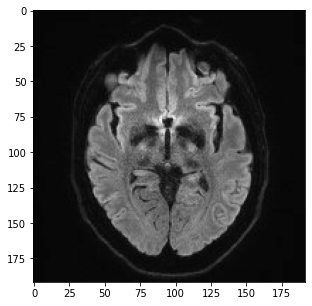

In [16]:
# unnormalized image
n_images = 1
plt.figure(figsize=(5,5))
j = 404
for i in range(n_images):
    fig = plt.subplot(1,n_images,i+1)
    fig.imshow(X[j,:,:,i], cmap = "gray")
print("min , max & sd : ",np.min(X[1]), np.max(X[1]), np.std(X[1]))

In [17]:
def cropp_img(X, method = "global"):
    """
    crops an MRI image into size of visible brain area
    returns: list uf cropped images
    """
    cropped = []
    thl =[]
    for i in range(X[:,:,:,:].shape[0]):
        im = X[i,:,:,:]
        im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY).astype(np.uint8)
        th = np.quantile(im, q = 0.70)
        thl.append(th)
        if method == "global":
            _, thresh = cv2.threshold(im, th, 255, 0)
        elif method == "otsu":
            blur = cv2.GaussianBlur(im,(49,49),0)
            _,thresh = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        else:
            print('invalid method')
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        c = np.vstack(contours).reshape(-1,2)
        xmin = np.min(c[:,0])
        ymin = np.min(c[:,1])
        xmax = np.max(c[:,0])
        ymax = np.max(c[:,1])
        img = im[ymin:ymax, xmin:xmax]
        #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (192,192), interpolation = cv2.INTER_CUBIC)
        img.astype(np.float64)
        cropped.append(img)
    return(cropped,thl)

In [18]:
def norm_image(X, crop):
    if crop:
        X_crop,thl = cropp_img(X, method = "global")
        X_crop = np.stack(X_crop, axis=0 )
        X_norm = preprocess_input(X_crop, mode='tf')
    else:
        X_1Ch =[]
        for i in range(X[:,:,:,:].shape[0]):
            X_1Ch.append(cv2.cvtColor(X[i,:,:,:],cv2.COLOR_BGR2GRAY).astype(np.float64))
        X_1Ch = np.stack(X_1Ch, axis=0 )
        X_norm = preprocess_input(X_1Ch, mode='tf')
        print(X_norm.shape)
    return X_norm   

X_norm = norm_image(X, crop = True)
print(X.shape)
print(X_norm.shape)

(13908, 192, 192, 3)
(13908, 192, 192)


In [19]:
# consider stroke and no-stroke patients separately:
from sklearn.model_selection import train_test_split

# consider stroke and no-stroke patients separately:
def split_data(X, Y_pat, Y_img, Y_mrs):   
    # stroke patients
    idx1 = np.where(Y_mrs >0)[0]
    X1 = X[idx1]
    Y1_pat = Y_pat[idx1]
    Y1_img = Y_img[idx1]
    Y1_mrs = Y_mrs[idx1]
    # no stroke patients
    idx0 = np.where(Y_mrs == 0)[0]
    X0 = X[idx0]
    Y0_pat = Y_pat[idx0]
    Y0_img = Y_img[idx0]
    Y0_mrs = Y_mrs[idx0]
    # train test split - Stroke patients:
    X1_train, X1_test, y1_train, y1_test = train_test_split(
        X1, Y1_mrs, test_size=0.20, shuffle = True, random_state=2021)
    # train val split - Stroke patients:
    X1_train, X1_valid, y1_train, y1_valid = train_test_split(
        X1_train, y1_train, test_size=0.25, shuffle = True, random_state=2021)
    print("Stroke patients: ")
    print('train shapes: ', X1_train.shape , y1_train.shape)
    print('validation shapes: ', X1_valid.shape , y1_valid.shape)
    print('test shapes: ', X1_test.shape , y1_test.shape)
    # train test split - noStroke patients:
    X0_train, X0_test, y0_train, y0_test = train_test_split(
        X0, Y0_mrs, test_size=0.20, shuffle = True, random_state=2021)
    # train val split - Stroke patients:
    X0_train, X0_valid, y0_train, y0_valid = train_test_split(
        X0_train, y0_train, test_size=0.25, shuffle = True, random_state=2021)
    print("\nControl: ")
    print('train shapes: ', X0_train.shape , y0_train.shape)
    print('validation shapes: ', X0_valid.shape , y0_valid.shape)
    print('test shapes: ', X0_test.shape , y0_test.shape)   
    #concat train
    X_train = np.concatenate([X1_train , X0_train], axis=0)
    y_train = np.concatenate([y1_train , y0_train], axis=0)
    #concat valid
    X_valid = np.concatenate([X1_valid , X0_valid], axis=0)
    y_valid = np.concatenate([y1_valid , y0_valid], axis=0)
    # concat test
    X_test = np.concatenate([X1_test , X0_test], axis=0)
    y_test = np.concatenate([y1_test , y0_test], axis=0)
    # converto target variable to categorical output
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
    y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=3)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
    print('\nMerged shapes:')
    print('train shapes: ', X_train.shape , y_train.shape)
    print('validation shapes: ', X_valid.shape , y_valid.shape)
    print('test shapes: ', X_test.shape , y_test.shape)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

    
X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(X_norm, Y_pat, Y_img,Y_mrs)

Stroke patients: 
train shapes:  (1775, 192, 192) (1775,)
validation shapes:  (592, 192, 192) (592,)
test shapes:  (592, 192, 192) (592,)

Control: 
train shapes:  (6569, 192, 192) (6569,)
validation shapes:  (2190, 192, 192) (2190,)
test shapes:  (2190, 192, 192) (2190,)

Merged shapes:
train shapes:  (8344, 192, 192) (8344, 3)
validation shapes:  (2782, 192, 192) (2782, 3)
test shapes:  (2782, 192, 192) (2782, 3)


### Define the CNN and the function for prediction

In [20]:
import pandas as pd
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Lambda, Conv2D, MaxPool2D,AveragePooling2D,GlobalAveragePooling2D, Reshape, concatenate
from keras.layers.normalization import BatchNormalization
from keras import initializers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(2021)

In [21]:
# Initialize hyperparameters
input_shape = (X_train.shape[1],X_train.shape[2], 1)
batch_size = 64
n_epochs = 400
print(input_shape)

(192, 192, 1)


## CNN Model GAP

In [22]:
def model_gap(input_shape, drop_level = 0.3):
    """
    moodel with 5 Con-blocks and global average pooling
    """
    # initialize Model
    model = Sequential()
    # Convolutional Block 1
    model.add(Conv2D(32, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same', input_shape = input_shape) )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 2
    model.add(Conv2D(64, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 3
    model.add(Conv2D(128, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 4
    model.add(Conv2D(256, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 5
    model.add(Conv2D(512, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))

    # Flat Part
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(3, kernel_initializer=initializers.he_normal(seed=3004), activation='softmax'))
    
    return model

model = model_gap(input_shape, drop_level = 0.3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 192, 192, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 192, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 192, 32)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 96, 96, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 64)       

In [23]:
def model_dense(input_shape, drop_level = 0.3):
    """
    moodel with 5 Con-blocks and dense layers
    """
    # initialize Model
    model = Sequential()
    # Convolutional Block 1
    model.add(Conv2D(32, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same', input_shape = input_shape) )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 2
    model.add(Conv2D(64, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 3
    model.add(Conv2D(128, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 4
    model.add(Conv2D(256, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 5
    model.add(Conv2D(512, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Dense Part
    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=initializers.he_normal(seed=3004)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(128, kernel_initializer=initializers.he_normal(seed=3004)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(2, kernel_initializer=initializers.he_normal(seed=3004), activation='softmax'))
    
    return model

#model = model_dense(input_shape , drop_level = 0.3)


In [24]:
def model_shallow(input_shape, drop_level = 0.3):
    """
    moodel with 5 Con-blocks and dense layers
    """
    # initialize Model
    model = Sequential()
    # Convolutional Block 1
    model.add(Conv2D(32, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same', input_shape = input_shape) )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 2
    model.add(Conv2D(64, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 3
    model.add(Conv2D(128, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Flat Part
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(2, kernel_initializer=initializers.he_normal(seed=3004), activation='softmax'))
    
    return model

#model = model_shallow(input_shape , drop_level = 0.3)


In [25]:
def model_flat(input_shape, drop_level = 0.3):
    """
    moodel with 5 Con-blocks and global average pooling
    """
    # initialize Model
    model = Sequential()
    # Convolutional Block 1
    model.add(Conv2D(32, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same', input_shape = input_shape) )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 2
    model.add(Conv2D(64, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 3
    model.add(Conv2D(128, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 4
    model.add(Conv2D(256, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 5
    model.add(Conv2D(512, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Flat Part
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(2, kernel_initializer=initializers.he_normal(seed=3004), activation='softmax'))
    
    return model

#model = model_flat(input_shape, drop_level = 0.3)


In [26]:
X_train = np.expand_dims(X_train, axis=3)
X_valid = np.expand_dims(X_valid, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [27]:
from datetime import datetime
import re

train_model = True

# Initialize hyperparameters
input_shape = (X_train.shape[1],X_train.shape[2], 1)
batch_size = 64
n_epochs = 400
print(input_shape)

if train_model:
    
    #### Train the model
    print('#### Training')
    # generate an output folder which contains the output of the current run
    print('Generate an output folder')
    output_folder_tmp = output_folder  + re.sub(r'[\W_]', '_', str(datetime.now())[0:19])
    if not exists(output_folder_tmp):
        os.mkdir(output_folder_tmp)
        os.mkdir(output_folder_tmp + '/checkpoints')
        
    print(output_folder_tmp)
    # load the model
    print('# model loaded #')
    model = model
    
    print('# model compiled #')
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # Data augmentation
    print('# Data Augmentation #')
    datagen = ImageDataGenerator(width_shift_range=0.3, 
                                 height_shift_range=0.3, 
                                 rotation_range=20, 
                                 zoom_range=0.5, 
                                 shear_range=0.2,
                                 vertical_flip=True,
                                 horizontal_flip = True)
    
    datagen.fit(X_train, seed=3004)
    
    cp_callback = ModelCheckpoint(output_folder_tmp + '/checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5', 
                                  monitor='val_loss', 
                                  verbose=1, 
                                  save_best_only=False, 
                                  save_weights_only=False, 
                                  mode='auto', 
                                  period=1)
    
    print('# Start training #')
    results = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size, shuffle = True), 
                                  steps_per_epoch=len(X_train)/batch_size, 
                                  epochs=n_epochs, 
                                  callbacks=[cp_callback],
                                  validation_data=(X_valid, y_valid))

# save model
model.save("cnn_mrs_ord.h5")
# eval model
model.evaluate( x=X_test, y=y_test, verbose=1)


(192, 192, 1)
#### Training
Generate an output folder
/tf/notebooks/avci/XAI/mrs/2021_06_26_10_06_43
# model loaded #
# model compiled #
# Data Augmentation #
# Start training #
Epoch 1/400
131/130 [==============================] - 20s 150ms/step - loss: 0.6763 - accuracy: 0.7622 - val_loss: 0.7012 - val_accuracy: 0.7103

Epoch 00001: saving model to /tf/notebooks/avci/XAI/mrs/2021_06_26_10_06_43/checkpoints/01-0.70.hdf5
Epoch 2/400
131/130 [==============================] - 16s 124ms/step - loss: 0.6134 - accuracy: 0.7854 - val_loss: 0.7954 - val_accuracy: 0.6305

Epoch 00002: saving model to /tf/notebooks/avci/XAI/mrs/2021_06_26_10_06_43/checkpoints/02-0.80.hdf5
Epoch 3/400
131/130 [==============================] - 16s 123ms/step - loss: 0.5869 - accuracy: 0.7905 - val_loss: 0.5732 - val_accuracy: 0.8102

Epoch 00003: saving model to /tf/notebooks/avci/XAI/mrs/2021_06_26_10_06_43/checkpoints/03-0.57.hdf5
Epoch 4/400
131/130 [==============================] - 16s 123ms/step - loss: 

In [29]:
val_loss = results.history["val_loss"]
val_acc = results.history["val_accuracy"]
train_loss = results.history["loss"]
train_acc = results.history["accuracy"]
df = pd.DataFrame.from_dict(results.history)
df.to_csv(output_folder_tmp +'/history.csv')

# Plot Predictions 

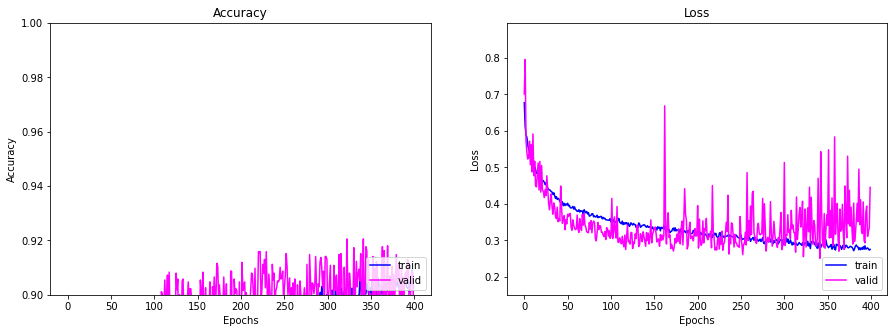

Max. validation accuracy:  0.9206
In epoch:  (array([322, 341]),)
Min. validation loss:  0.251
In epoch:  (array([341]),)


In [30]:
def plot_res(df):
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.plot(df['accuracy'], 'blue')
    plt.plot(df['val_accuracy'], 'magenta')
    plt.ylim(0.9, 1)
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'valid'], loc = 'lower right')
    plt.subplot(1,2,2)
    plt.plot(df['loss'], 'blue')
    plt.plot(df['val_loss'], 'magenta')
    plt.ylim(np.min([np.min(df['val_loss']), np.min(df['loss'])])-0.1, 
             np.max([np.max(df['val_loss']), np.max(df['loss'])])+0.1)
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'valid'], loc = 'lower right')
    plt.show();
    print("Max. validation accuracy: ", round(np.max(df['val_accuracy']),4))
    print('In epoch: ', np.where(df['val_accuracy']== np.max(df['val_accuracy'])))
    print("Min. validation loss: ", round(np.min(df['val_loss']),4))
    print('In epoch: ', np.where(df['val_loss'] == np.min(df['val_loss'])))

plot_res(df)

In [35]:

# get performance metrics
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.proportion import proportion_confint
from sklearn import metrics

model = keras.models.load_model('/tf/notebooks/avci/XAI/mrs/2021_06_26_10_06_43/checkpoints/342-0.25.hdf5')


y_pred = model_mrs.predict(X_test)
# NLL
NLL, Acc = model_mrs.evaluate( x=X_test, y=y_test, verbose=0)

# cm 
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis =1))

#acc
nobs = sum(sum(cm))
count = sum([cm[0,0], cm[1,1]], cm[2,2])
acc_ci_low, acc_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')

#acc 0
nobs = sum(cm[0,])
count = cm[0,0]
acc0 = count/nobs
acc0_ci_low, acc0_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')

#acc 1
nobs = sum(cm[1,])
count = cm[1,1]
acc1 = count/nobs
acc1_ci_low, acc1_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')

#acc 2
nobs = sum(cm[2,])
count = cm[2,2]
acc2 = count/nobs
acc2_ci_low, acc2_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')


print("\nPerformance on Test Set : ")
print("\nAccuracy         [95% Conf.] :", np.around(Acc,4),np.around([acc_ci_low, acc_ci_upp],4))
print("Accuracy Class 0 [95% Conf.] :", np.around(acc0,4),np.around([acc0_ci_low, acc0_ci_upp],4))
print("Accuracy Class 1 [95% Conf.] :", np.around(acc1,4),np.around([acc1_ci_low, acc1_ci_upp],4))
print("Accuracy Class 2 [95% Conf.] :", np.around(acc2,4),np.around([acc2_ci_low, acc2_ci_upp],4))
print("Negative Log-Likelihood      :", np.around(NLL, 4))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2190
           1       0.69      0.67      0.68       389
           2       0.59      0.38      0.46       203

    accuracy                           0.89      2782
   macro avg       0.74      0.68      0.70      2782
weighted avg       0.88      0.89      0.88      2782


Performance on Test Set : 

Accuracy    [95% Conf.] : 0.8914 [0.8505 0.876 ]
Sensitivity [95% Conf.] : 0.7436 [0.6954 0.7865]
Specificity [95% Conf.] : 0.9848 [0.9788 0.9892]


NameError: name 'AUC' is not defined